In [1]:
import torch
import torchvision
import torch.nn as nn
from base64 import b64encode
import torch.nn.functional as F
from IPython.display import HTML
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader

import os,cv2,gc
import skvideo.io
import numpy as np
from tqdm import tqdm
import copy,glob,pickle
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import zipfile
with zipfile.ZipFile('drive/My Drive/accident_dataset_v1.zip', 'r') as zfile:
  zfile.extractall("./")

In [2]:
DATA_DIR = "accident_dataset_v1/"
BATCH_SIZE = 16
EPOCHS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FPS = 2
NUM_SEGS = 20
IMG_SIZE = (200,350)

LR = 0.009
ITERS_TO_ACC = 2
MAX_NORM = None
USE_AMP = [True if DEVICE==torch.device('cuda') else False][0]

config_dict = {'use_amp': USE_AMP, 'iters_to_accumlate': ITERS_TO_ACC, 'max_norm': MAX_NORM, 'device': DEVICE}
print(config_dict)

{'use_amp': True, 'iters_to_accumlate': 2, 'max_norm': None, 'device': device(type='cuda')}


In [3]:
print("Train dataset: ")
print('Positive: ',len(glob.glob(DATA_DIR+'train/positive/*')))
print('Negative: ',len(glob.glob(DATA_DIR+'train/negative/*')))

print("\nValidation dataset: ")
print('Positive: ',len(glob.glob(DATA_DIR+'val/positive/*')))
print('Negative: ',len(glob.glob(DATA_DIR+'val/negative/*')))

Train dataset: 
Positive:  196
Negative:  180

Validation dataset: 
Positive:  18
Negative:  18


In [ ]:
# script to print video duration
times_lis = []

for temp_pth in tqdm(glob.glob(DATA_DIR+'train/*/*')):
  temp_frame = cv2.VideoCapture(temp_pth)
  temp_fc = temp_frame.get(cv2.CAP_PROP_FRAME_COUNT)
  temp_fps = temp_frame.get(cv2.CAP_PROP_FPS)
  times_lis.append((int(temp_fc/temp_fps)/60,temp_pth))
  
print(sorted(times_lis,reverse=True))

100%|██████████| 376/376 [00:16<00:00, 23.44it/s]

[(2.4833333333333334, 'accident_dataset_v1/train/positive/kcp_toAVI.avi'), (0.5, 'accident_dataset_v1/train/positive/jubli check post_toAVI.avi'), (0.38333333333333336, 'accident_dataset_v1/train/positive/videoplayback (19)_Trim.mp4'), (0.35, 'accident_dataset_v1/train/positive/videoplayback (100)_Trim.mp4'), (0.31666666666666665, 'accident_dataset_v1/train/positive/videoplayback (77)_Trim.mp4'), (0.3, 'accident_dataset_v1/train/positive/videoplayback (48)_Trim.mp4'), (0.3, 'accident_dataset_v1/train/positive/videoplayback (26)_Trim.mp4'), (0.3, 'accident_dataset_v1/train/positive/MJ Market.avi'), (0.26666666666666666, 'accident_dataset_v1/train/positive/videoplayback (11)_Trim.mp4'), (0.25, 'accident_dataset_v1/train/positive/videoplayback (37)_Trim.mp4'), (0.23333333333333334, 'accident_dataset_v1/train/positive/videoplayback (99)_Trim.mp4'), (0.23333333333333334, 'accident_dataset_v1/train/positive/videoplayback (94)_Trim.mp4'), (0.23333333333333334, 'accident_dataset_v1/train/posit

In [ ]:
# Error - 146
# Deleting very long videos due to memory limitations
os.remove('accident_dataset_v1/train/positive/chaderghat_toAVI.avi')
os.remove('accident_dataset_v1/train/positive/CTO20100506_toAVI.avi')

In [7]:
class VideoClassifier(nn.Module):
  def __init__(self):
    super(VideoClassifier,self).__init__()
    self.ptm = torchvision.models.video.r2plus1d_18(pretrained=True)
    self.ptm.fc = nn.Linear(self.ptm.fc.in_features,256)
    self.fc1 = nn.Linear(256,64)
    self.fc2 = nn.Linear(64,1)
  
  @torch.cuda.amp.autocast(enabled=config_dict['use_amp'])
  def __call__(self,x):
    x = self.ptm(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [8]:
class VideoDataset(Dataset):
  
  def __init__(self,vid_dir,num_segments,frames_per_segment,img_size,split):
    self.vid_dir = vid_dir
    self.img_size = img_size
    self.num_segs = num_segments
    self.fps = frames_per_segment
    self.vids_list = glob.glob(vid_dir+split+'/*/*')
    self.transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989])])

  def __len__(self):
    return len(self.vids_list)
  
  def __preprocess(self,vid_arr,num_segs,fps):
    frame_idx = 0
    segs = np.array_split(np.arange(vid_arr.shape[0]),num_segs)
    final_vid_arr = torch.empty((3,fps*num_segs,*self.img_size))

    for seg in segs:
      idxs = np.sort(np.random.choice(seg,fps))
      for idx in idxs:
        frame = cv2.resize(vid_arr[idx],(self.img_size[1],self.img_size[0]))
        final_vid_arr[:,frame_idx,:,:] = self.transforms(frame)
        frame_idx +=1

    return final_vid_arr

  def __getitem__(self,idx):

    vid_filename = self.vids_list[idx]
    vid_label = torch.tensor([[1.0 if os.path.basename(os.path.dirname(vid_filename))=='positive' else 0.0]])
    vid_array = np.array(skvideo.io.vread(vid_filename))

    if self.num_segs > vid_array.shape[0]:
      temp_vid_arr = self.__preprocess(vid_array,vid_array.shape[0],1)
      repeat_times = self.fps * self.num_segs - vid_array.shape[0]
      repeat_frames_arr = torch.cat([temp_vid_arr[:,-1:,:,:]] * repeat_times,axis=1)
      final_vid_arr = torch.cat([temp_vid_arr,repeat_frames_arr],axis=1)
    else:
      final_vid_arr = self.__preprocess(vid_array,self.num_segs,self.fps)

    return {'video_array': final_vid_arr, 'label': vid_label}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Video array shape:  torch.Size([3, 40, 200, 350])


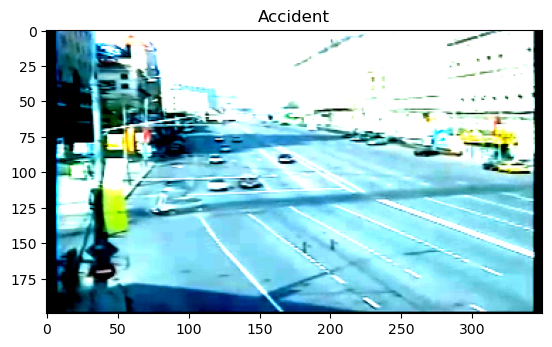

In [9]:
viz_idx = 146
viz_ds = VideoDataset(DATA_DIR,NUM_SEGS,FPS,IMG_SIZE,'train')
viz_example = viz_ds[viz_idx]
viz_arr = viz_example['video_array']
viz_label = viz_example['label']

print('Video array shape: ', viz_arr.shape)
plt.imshow(viz_arr[:,np.random.choice(viz_arr.shape[1]),:,:].permute(1,2,0))
plt.title(['Accident' if viz_label.item()==1 else 'No Accident'][0])
plt.show()

In [10]:
# Create training and validation datasets
image_datasets = {mode: VideoDataset(DATA_DIR,NUM_SEGS,FPS,IMG_SIZE,mode) for mode in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {mode: torch.utils.data.DataLoader(image_datasets[mode],batch_size=BATCH_SIZE,
shuffle=True,pin_memory=True,drop_last=False, num_workers=2) for mode in ['train', 'val']}
# Send the model to device
model = VideoClassifier()

In [11]:
for params in list(model.parameters())[:-6]:
  params.requires_grad = False

print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t",name)

Params to learn:
	 ptm.fc.weight
	 ptm.fc.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


In [12]:
class MetricMonitor:
  def __init__(self):
    self.reset()
  def reset(self):
    self.vals = 0
    self.total = 0
  def update(self,val,count=1):
    self.vals += val
    self.total += count
  def result(self):
    if self.total == 0:
      return 0
    return self.vals/self.total 


def calculate_accuracy(output,target):
    output = torch.sigmoid(output)
    output = (output >= 0.5)
    return ((target == output).sum(0)) / target.shape[0]

calculate_accuracy(torch.tensor([100.,0.,0.,100.]).view(-1,1),torch.tensor([1.,0.,0.,1.]).view(-1,1))

tensor([0.5000])

In [13]:
def train_model(model, dataset_loaders, criterion, optimizer, params_to_update, epochs, config):

    best_val_acc = 0.0
    val_acc_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    scaler = torch.cuda.amp.GradScaler(enabled=config['use_amp'])

    for epoch_count in range(epochs):
      optimizer.zero_grad(set_to_none=True)

      for mode in ["train","val"]:
          if mode == "train":
              model.train()
          elif mode == "val":
              model.eval()
          
          loss_monitor = MetricMonitor()
          acc_monitor = MetricMonitor()
          stream = tqdm(dataset_loaders[mode])
          effec_iters_acc = config['iters_to_accumlate'] 

          for batch_number,inputs in enumerate(stream):

              gc.collect()
              torch.cuda.empty_cache()
              vid_arr = inputs["video_array"].to(config['device'],non_blocking=True)
              target = inputs["label"].to(config['device'],non_blocking=True).view(-1, 1)
              iters_remainder = (len(stream) % config['iters_to_accumlate'])

              if (batch_number == len(stream)-iters_remainder) and iters_remainder != 0:
                  effec_iters_acc = iters_remainder
                  #print(batch_number,iters_remainder) 
              
              with torch.cuda.amp.autocast(enabled=config['use_amp']):
                  with torch.set_grad_enabled(mode == 'train'):
                      output = model(vid_arr)
                      accuracy = calculate_accuracy(output,target)
                      loss = criterion(output,target)
                      if mode == 'train':
                        loss = loss / effec_iters_acc
                                       
              if mode == "train":                
                scaler.scale(loss).backward()
                if (batch_number+1)%config['iters_to_accumlate']==0 or (batch_number+1)==len(stream):                                        
                    if config['max_norm'] != None:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(params_to_update, config['max_norm'])
                    scaler.step(optimizer)
                    scaler.update()                          
                    optimizer.zero_grad(set_to_none=True)
                            
              if mode == 'train':
                denominator = effec_iters_acc * target.shape[0]
                loss_monitor.update(loss.item() * denominator, target.shape[0])
                acc_monitor.update(accuracy.item() * target.shape[0], target.shape[0])
                batch_summary = [f'loss: {loss_monitor.result():.4}', f'accuracy: {acc_monitor.result():.4}']

                if batch_number==0 or (batch_number+1)%config['iters_to_accumlate']==0 or ((batch_number+1)==len(stream)):
                  stream.set_description(f"{mode.capitalize()} - Epoch: {epoch_count+1}/{epochs} - " +
                  f"Batch: {batch_number+1}/{len(dataset_loaders[mode])} - {' | '.join(batch_summary)}")

              else:
                loss_monitor.update(loss.item() * target.shape[0], target.shape[0])
                acc_monitor.update(accuracy.item() * target.shape[0], target.shape[0])
                batch_summary = [f'loss: {loss_monitor.result():.4}', f'accuracy: {acc_monitor.result():.4}']

                stream.set_description(f"{mode.capitalize()} - Epoch: {epoch_count+1}/{epochs} - " +
                f"Batch: {batch_number+1}/{len(dataset_loaders[mode])} - {' | '.join(batch_summary)}")
     
      val_acc = acc_monitor.result()
      val_acc_history.append(val_acc)
      val_loss_history.append(loss_monitor.result())
      
      if val_acc >= best_val_acc:
        best_val_acc = val_acc
        print('Best accuracy: ', best_val_acc)
        save_model = model.state_dict()
        
        if torch.cuda.device_count() > 1:
            save_model = model.module.state_dict()                        
        best_model_wts = copy.deepcopy(save_model)            
      print('-' * 120, '\n')
    
    return best_model_wts,val_acc_history,val_loss_history

In [14]:
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    print(f'Using {torch.cuda.device_count()} gpus !')

model = model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr = 0.006)

Using 2 gpus !


In [15]:
best_model_wts,val_acc_hist,val_loss_hist = train_model(model, dataloaders_dict, criterion, optimizer,
                                                        params_to_update, EPOCHS, config_dict)

Train - Epoch: 1/8 - Batch: 24/24 - loss: 2.069 | accuracy: 0.5186: 100%|██████████| 24/24 [05:17<00:00, 13.21s/it]
Val - Epoch: 1/8 - Batch: 3/3 - loss: 0.7972 | accuracy: 0.5: 100%|██████████| 3/3 [00:29<00:00,  9.86s/it]   


Best accuracy:  0.5
------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 2/8 - Batch: 24/24 - loss: 0.5919 | accuracy: 0.6596: 100%|██████████| 24/24 [05:21<00:00, 13.38s/it]
Val - Epoch: 2/8 - Batch: 3/3 - loss: 0.4546 | accuracy: 0.7222: 100%|██████████| 3/3 [00:27<00:00,  9.31s/it]


Best accuracy:  0.7222222222222222
------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 3/8 - Batch: 24/24 - loss: 0.3046 | accuracy: 0.8617: 100%|██████████| 24/24 [05:11<00:00, 12.97s/it]
Val - Epoch: 3/8 - Batch: 3/3 - loss: 0.112 | accuracy: 0.9722: 100%|██████████| 3/3 [00:28<00:00,  9.53s/it] 


Best accuracy:  0.9722222222222222
------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 4/8 - Batch: 24/24 - loss: 0.1865 | accuracy: 0.9176: 100%|██████████| 24/24 [05:07<00:00, 12.79s/it]
Val - Epoch: 4/8 - Batch: 3/3 - loss: 0.05407 | accuracy: 1.0: 100%|██████████| 3/3 [00:26<00:00,  8.85s/it]


Best accuracy:  1.0
------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 5/8 - Batch: 24/24 - loss: 0.0861 | accuracy: 0.9601: 100%|██████████| 24/24 [05:11<00:00, 12.97s/it] 
Val - Epoch: 5/8 - Batch: 3/3 - loss: 0.03256 | accuracy: 1.0: 100%|██████████| 3/3 [00:31<00:00, 10.35s/it]


Best accuracy:  1.0
------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 6/8 - Batch: 24/24 - loss: 0.3204 | accuracy: 0.883: 100%|██████████| 24/24 [05:19<00:00, 13.33s/it] 
Val - Epoch: 6/8 - Batch: 3/3 - loss: 0.292 | accuracy: 0.8611: 100%|██████████| 3/3 [00:27<00:00,  9.30s/it]


------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 7/8 - Batch: 24/24 - loss: 0.1778 | accuracy: 0.9362: 100%|██████████| 24/24 [05:18<00:00, 13.29s/it]
Val - Epoch: 7/8 - Batch: 3/3 - loss: 0.3455 | accuracy: 0.8333: 100%|██████████| 3/3 [00:30<00:00, 10.21s/it]


------------------------------------------------------------------------------------------------------------------------ 



Train - Epoch: 8/8 - Batch: 24/24 - loss: 0.2808 | accuracy: 0.883: 100%|██████████| 24/24 [05:29<00:00, 13.74s/it] 
Val - Epoch: 8/8 - Batch: 3/3 - loss: 0.1727 | accuracy: 0.9444: 100%|██████████| 3/3 [00:31<00:00, 10.53s/it]

------------------------------------------------------------------------------------------------------------------------ 



In [17]:
# Specify a path and save the model wts
PATH = "accident_detection.pt"
torch.save(best_model_wts, PATH)

loaded_wts = best_model_wts
#loaded_wts = torch.load("accident_detection.pt")

In [26]:
pred_model = VideoClassifier()
pred_model.load_state_dict(loaded_wts)

if torch.cuda.device_count() > 1:    
    pred_model = torch.nn.DataParallel(pred_model)
    print(f'Using {torch.cuda.device_count()} gpus !')
         
pred_model = pred_model.to(DEVICE)
pred_ds = VideoDataset(DATA_DIR,NUM_SEGS,FPS,IMG_SIZE,'val')
pred_idx = np.random.choice(len(pred_ds))
    
pred_example = pred_ds[pred_idx]
pred_arr = pred_example['video_array'].to(DEVICE)
pred_label = pred_example['label'].to(DEVICE)

pred_label_str = ['Accident' if pred_label.item()==1 else 'No Accident'][0]
prediction = torch.sigmoid(pred_model(torch.unsqueeze(pred_arr,0))).item()
prediction_str = ['Accident' if prediction >= 0.5 else 'No Accident'][0]

print('Real label: ' + pred_label_str + '\nPredicted label: ' + prediction_str)

# Input video path
save_path = pred_ds.vids_list[pred_idx]
print(save_path)

# Show video
mp4 = open(save_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Using 2 gpus !
Real label: Accident
Predicted label: Accident
accident_dataset_v1/val/positive/38.mp4
